# MongoDB에서 모든 레시피를 가져와 데이터 전처리

In [148]:
import os
from db_config_cp.db import MongoDB 
import pandas as pd

def get_recipes_and_save_to_csv():
    """
    MongoDB에서 모든 레시피를 가져와 CSV로 저장
    """
    with MongoDB() as mongo_db:
        try:
            collection_name = "recipe"  # MongoDB 컬렉션 이름
            projection = {
                "title": 1, "type_key": 1, "method_key": 1,
                "servings": 1, "cooking_time": 1,
                "ingredients": 1, "cooking_steps": 1,
                "difficulty": 1, "tips": 1, "recipe_type": 1
            }
            
            print("레시피 데이터를 가져오는 중...")
            # limit 없이 모든 문서 가져오기
            recipes = mongo_db.find_many(collection_name, {}, projection)

            # 데이터프레임으로 변환
            print("데이터프레임 변환 중...")
            recipes_list = [dict(recipe) for recipe in recipes]
            for recipe in recipes_list:
                recipe['_id'] = str(recipe['_id'])  # ObjectId를 문자열로 변환

            df = pd.DataFrame(recipes_list)
            print(f"변환된 데이터 크기: {len(df)}행 x {len(df.columns)}열")
            
            # CSV 파일 저장 경로
            csv_file_path = os.path.join(os.getcwd(), "data/recipeinfo_example_dataset.csv")
            df.to_csv(csv_file_path, index=False)
            print(f"레시피 데이터를 {csv_file_path}에 저장했습니다.")
            
            # 데이터 검증
            print(df.info())
            print("\n=== 데이터 검증 ===")
            print("Type key 분포:")
            print(df['type_key'].value_counts())
            print("\nMethod key 분포:")
            print(df['method_key'].value_counts())
            print("\nServings 분포:")
            print(df['servings'].value_counts())
            
        except Exception as e:
            print(f"get_recipes_and_save_to_csv() 오류 발생: {e}")
        
        return df
df_recipes = get_recipes_and_save_to_csv()

레시피 데이터를 가져오는 중...
find_many 호출됨 - 컬렉션: recipe, limit: None
데이터프레임 변환 중...
변환된 데이터 크기: 18268행 x 11열
레시피 데이터를 /Users/minji/workspace/ts-ai/src/evaluation/data/recipeinfo_example_dataset.csv에 저장했습니다.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   _id            18268 non-null  object
 1   title          18268 non-null  object
 2   type_key       18268 non-null  object
 3   method_key     18268 non-null  object
 4   servings       18268 non-null  object
 5   cooking_time   18268 non-null  object
 6   difficulty     18268 non-null  object
 7   ingredients    18268 non-null  object
 8   cooking_steps  18268 non-null  object
 9   tips           18268 non-null  object
 10  recipe_type    18268 non-null  object
dtypes: object(11)
memory usage: 1.5+ MB
None

=== 데이터 검증 ===
Type key 분포:
type_key
반찬         9178
밥/죽/떡       929
국/찌개        897
면/

## 데이터 전처리 & 분포 확인 함수 생성
- 매운맛 관련 컬럼 생성
- servings 이상값 고치기

In [149]:
import re

def detect_spicy_level(recipe_type):
    """
    레시피 타입에서 매운맛 단계를 검출하는 함수
    매운맛이 없으면 '매운맛없음' 반환
    """
    if isinstance(recipe_type, str):
        # 문자열이 들어온 경우 리스트로 변환
        try:
            recipe_type = eval(recipe_type)
        except:
            return "매운맛없음"
    
    if not isinstance(recipe_type, list):
        return "형식지정이상함"
        
    # 매운맛 단계 검출
    spicy_pattern = r'매운맛(\d)단계'
    for type_item in recipe_type:
        match = re.search(spicy_pattern, str(type_item))
        if match:
            return f"매운맛{match.group(1)}단계"
    
    return "매운맛없음"
df_recipes['spicy_level'] = df_recipes['recipe_type'].apply(detect_spicy_level)
df_recipes.spicy_level.value_counts()

spicy_level
매운맛없음     13193
매운맛1단계     4594
매운맛2단계      381
매운맛3단계       65
매운맛4단계       31
매운맛5단계        4
Name: count, dtype: int64

In [150]:
# print("servings 컬럼의 데이터 타입:", df_recipes['servings'].dtype)
def fix_servings(df_recipes):
    # 문자열 값을 기반으로 변경
    mapping = {
        '': '  ',
        '1': '1인분',
        '2': '2인분',
        '4': '4인분',
        '5': '5인분',
        1: '1인분',    # 혹시 숫자 타입이 섞여 있을 경우를 대비
        2: '2인분',
        4: '4인분',
        5: '5인분'
    }

    # 변경 전 확인
    # print("변경 전:")
    # print(df_recipes['servings'].value_counts())

    # 값 변경
    df_recipes['servings'] = df_recipes['servings'].replace(mapping)

    # 변경 후 확인
    # print("\n변경 후:")
    # print(df_recipes['servings'].value_counts())
    # df_recipes.info()|

    return df_recipes

df_recipes = fix_servings(df_recipes)

In [151]:
def print_distribution(df_recipes: pd.DataFrame):
    print("=== Type Key 분포 ===")
    print(df_recipes['type_key'].value_counts())
    print(len(df_recipes['type_key'].value_counts()))
    print("\n=== Method Key 분포 ===")
    print(df_recipes['method_key'].value_counts())
    print(len(df_recipes['method_key'].value_counts()))
    print("\n=== Servings 분포 ===")
    print(df_recipes['servings'].value_counts())
    print(len(df_recipes['servings'].value_counts()))
    print("\n=== 매운맛 단계 분포 ===")
    print(df_recipes['spicy_level'].value_counts())
    print(len(df_recipes['spicy_level'].value_counts()))
print_distribution(df_recipes)

=== Type Key 분포 ===
type_key
반찬         9178
밥/죽/떡       929
국/찌개        897
면/만두        887
양식          876
빵/과자        876
샐러드         868
디저트         843
퓨전          807
스프          805
양념/잼/소스     801
차/음료/술      501
Name: count, dtype: int64
12

=== Method Key 분포 ===
method_key
끓이기    3592
볶음     3084
굽기     2813
부침     1882
무침     1876
조림     1753
찜      1195
튀김      772
절임      531
비빔      412
삶기      288
회        48
갈기       22
Name: count, dtype: int64
13

=== Servings 분포 ===
servings
2인분    6978
4인분    4142
1인분    3463
3인분    2539
        695
5인분     451
Name: count, dtype: int64
6

=== 매운맛 단계 분포 ===
spicy_level
매운맛없음     13193
매운맛1단계     4594
매운맛2단계      381
매운맛3단계       65
매운맛4단계       31
매운맛5단계        4
Name: count, dtype: int64
6


## 다음 함수들 적용한 것을 새롭게 csv로 저장
- df_recipes = get_recipes_and_save_to_csv() : mongodb에서 데이터 가져와서 csv에 저장
- df_recipes = fix_servings(df_recipes) : dataset에서 servings 이상한 것 고침
- df_recipes['spicy_level'] = df_recipes['recipe_type'].apply(detect_spicy_level) : 매운맛 단계 추출해서 컬럼 만듦

In [152]:
df_recipes.to_csv("data/recipeinfo_example_dataset.csv", index=False)

# 다양한 레시피 데이터셋 생성
type_key, method_key, servings가 다양하게 분포된 테스트용 데이터셋을 생성합니다.

In [153]:
import pandas as pd

# 원본 데이터 로드
df = pd.read_csv("data/recipeinfo_example_dataset.csv")
df.describe()

,_id,title,type_key,method_key,servings,cooking_time,difficulty,ingredients,cooking_steps,tips,recipe_type,spicy_level
count,18268,18268,18268,18268,18268,16663,17139,18268,18268,18268,18268,18268
unique,18268,17803,12,13,6,9,3,18210,18261,8889,9050,6
top,673c36d28fad4e3c931146b6,돼지고기 장조림,반찬,끓이기,2인분,30분 이내,초급,"['진미채(200g)', '고추장(2T)', '고춧가루(1T)', '올리고당(1.5...",['깻잎향이 봉지를 열자마자 솔솔깻잎 요때 직접따서 바로 먹을 깻잎김치 담그는법깻잎...,[],"['고단백', '한식', '반찬', '조림']",매운맛없음
freq,1,14,9178,3592,6978,6484,15914,3,2,9176,197,13193


## 2. 다양한 레시피 선택 함수 정의

In [154]:
# def get_balanced_unique_recipes(df):
#     """
#     spicy_level, type_key, method_key, servings 컬럼을 기준으로 중복되지 않고 균등하게 샘플링된 레시피를 반환.
    
#     Parameters:
#     df: 원본 레시피 DataFrame
    
#     Returns:
#     DataFrame: 중복되지 않고 균등하게 분포된 레시피
#     """
#     # 중복되지 않은 조합을 저장할 DataFrame
#     unique_recipes = pd.DataFrame()

#     # 각 컬럼별 값을 가져오기
#     spicy_levels = df['spicy_level'].unique()
#     type_keys = df['type_key'].unique()
#     method_keys = df['method_key'].unique()
#     servings = df['servings'].unique()

#     # 각 컬럼의 값들이 고르게 포함되도록 반복
#     for spicy in spicy_levels:
#         for type_key in type_keys:
#             for method in method_keys:
#                 for serving in servings:
#                     # 해당 조합에 맞는 레시피 추출
#                     filtered_df = df[
#                         (df['spicy_level'] == spicy) &
#                         (df['type_key'] == type_key) &
#                         (df['method_key'] == method) &
#                         (df['servings'] == serving)
#                     ]
#                     # 중복되지 않은 행 하나를 선택
#                     if not filtered_df.empty:
#                         unique_recipes = pd.concat(
#                             [unique_recipes, filtered_df.head(1)], ignore_index=True
#                         )

#     # 최종적으로 중복을 다시 제거
#     unique_recipes = unique_recipes.drop_duplicates(
#         subset=['spicy_level', 'type_key', 'method_key', 'servings'], keep='first'
#     )

#     return unique_recipes

# # 함수 실행
# df_sample = get_balanced_unique_recipes(df)
# df_sample.describe()


In [155]:
from collections import Counter

def get_diverse_recipes(df, n_samples=100):
    """
    type_key, method_key, servings, spicy_level이 다양하게 분포된 레시피 데이터셋을 생성.
    중복 제거를 하며 n_samples 이상을 확보할 때까지 반복.
    
    Parameters:
    df: 원본 레시피 DataFrame
    n_samples: 목표 샘플 수
    
    Returns:
    DataFrame: 선택된 레시피들
    """
    selected_indices = set()

    while True:
        # 분포 계산
        type_dist = Counter(df['type_key'])
        method_dist = Counter(df['method_key'])
        servings_dist = Counter(df['servings'])
        spicy_dist = Counter(df['spicy_level'])

        # 각 카테고리별 최소 샘플 수 계산
        min_type_samples = max(1, n_samples // len(type_dist))
        min_method_samples = max(1, n_samples // len(method_dist))
        min_servings_samples = max(1, n_samples // len(servings_dist))
        min_spicy_samples = max(1, n_samples // len(spicy_dist))

        # 1. 각 spicy_level에서 최소 샘플 확보
        for spicy_level in spicy_dist.keys():
            spicy_recipes = df[df['spicy_level'] == spicy_level]
            remaining = spicy_recipes[~spicy_recipes.index.isin(selected_indices)]
            if len(remaining) >= min_spicy_samples:
                selected = remaining.sample(n=min_spicy_samples).index
                selected_indices.update(selected)

        # 2. 각 type_key에서 최소 샘플 확보
        for type_key in type_dist.keys():
            type_recipes = df[df['type_key'] == type_key]
            remaining = type_recipes[~type_recipes.index.isin(selected_indices)]
            if len(remaining) >= min_type_samples:
                selected = remaining.sample(n=min_type_samples).index
                selected_indices.update(selected)

        # 3. 각 method_key에서 최소 샘플 확보
        for method_key in method_dist.keys():
            method_recipes = df[df['method_key'] == method_key]
            remaining = method_recipes[~method_recipes.index.isin(selected_indices)]
            if len(remaining) >= min_method_samples:
                selected = remaining.sample(n=min_method_samples).index
                selected_indices.update(selected)

        # 4. 각 servings에서 최소 샘플 확보
        for servings in servings_dist.keys():
            servings_recipes = df[df['servings'] == servings]
            remaining = servings_recipes[~servings_recipes.index.isin(selected_indices)]
            if len(remaining) >= min_servings_samples:
                selected = remaining.sample(n=min_servings_samples).index
                selected_indices.update(selected)

        # 중복 제거된 결과 생성
        diverse_recipes = df.loc[list(selected_indices)].drop_duplicates(
            subset=['type_key', 'method_key', 'servings', 'spicy_level'], keep='first'
        )

        # 종료 조건: n_samples 이상의 행이 확보되면 종료
        if len(diverse_recipes) >= n_samples:
            break

    return diverse_recipes

# 함수 실행
df_sample = get_diverse_recipes(df, n_samples=10)
df_sample.describe()


,_id,title,type_key,method_key,servings,cooking_time,difficulty,ingredients,cooking_steps,tips,recipe_type,spicy_level
count,37,37,37,37,37,33,35,37,37,37,37,37
unique,37,37,12,13,6,7,2,37,37,22,37,6
top,673c36d38fad4e3c931171ba,"토마토 마리네이드&냉파스타, 새콤달콤 시원한 별미",반찬,볶음,2인분,30분 이내,초급,"['방울토마토(1.5kg)', '양파(1개)', '파슬리가루(1스푼)', '올리브오...","['양파는 잘게 다져 준비해주세요양파(소) 1개', '방울토마토는 끓는물에 약 2분...",[],"['채식', '저칼로리', '새콤달콤한맛', '양식', '가벼운']",매운맛없음
freq,1,1,12,8,12,11,34,1,1,16,1,25


In [156]:
print_distribution(df_sample)

=== Type Key 분포 ===
type_key
반찬         12
면/만두        4
샐러드         3
스프          3
디저트         3
양식          2
밥/죽/떡       2
양념/잼/소스     2
차/음료/술      2
퓨전          2
국/찌개        1
빵/과자        1
Name: count, dtype: int64
12

=== Method Key 분포 ===
method_key
볶음     8
끓이기    7
굽기     6
무침     3
절임     2
삶기     2
조림     2
튀김     2
찜      1
회      1
비빔     1
부침     1
갈기     1
Name: count, dtype: int64
13

=== Servings 분포 ===
servings
2인분    12
1인분     8
3인분     8
4인분     6
        2
5인분     1
Name: count, dtype: int64
6

=== 매운맛 단계 분포 ===
spicy_level
매운맛없음     25
매운맛1단계     8
매운맛3단계     1
매운맛4단계     1
매운맛2단계     1
매운맛5단계     1
Name: count, dtype: int64
6


## 4. 데이터셋 저장

In [157]:
# CSV 파일로 저장
output_file = 'data/diverse_recipes_dataset.csv'
df_sample.to_csv(output_file, index=False)
print(f"다양한 레시피 데이터셋이 {output_file}에 저장되었습니다.")

# 저장된 데이터 확인
df_sample.describe()

다양한 레시피 데이터셋이 data/diverse_recipes_dataset.csv에 저장되었습니다.


,_id,title,type_key,method_key,servings,cooking_time,difficulty,ingredients,cooking_steps,tips,recipe_type,spicy_level
count,37,37,37,37,37,33,35,37,37,37,37,37
unique,37,37,12,13,6,7,2,37,37,22,37,6
top,673c36d38fad4e3c931171ba,"토마토 마리네이드&냉파스타, 새콤달콤 시원한 별미",반찬,볶음,2인분,30분 이내,초급,"['방울토마토(1.5kg)', '양파(1개)', '파슬리가루(1스푼)', '올리브오...","['양파는 잘게 다져 준비해주세요양파(소) 1개', '방울토마토는 끓는물에 약 2분...",[],"['채식', '저칼로리', '새콤달콤한맛', '양식', '가벼운']",매운맛없음
freq,1,1,12,8,12,11,34,1,1,16,1,25


## 6. 분포 시각화 (선택사항)

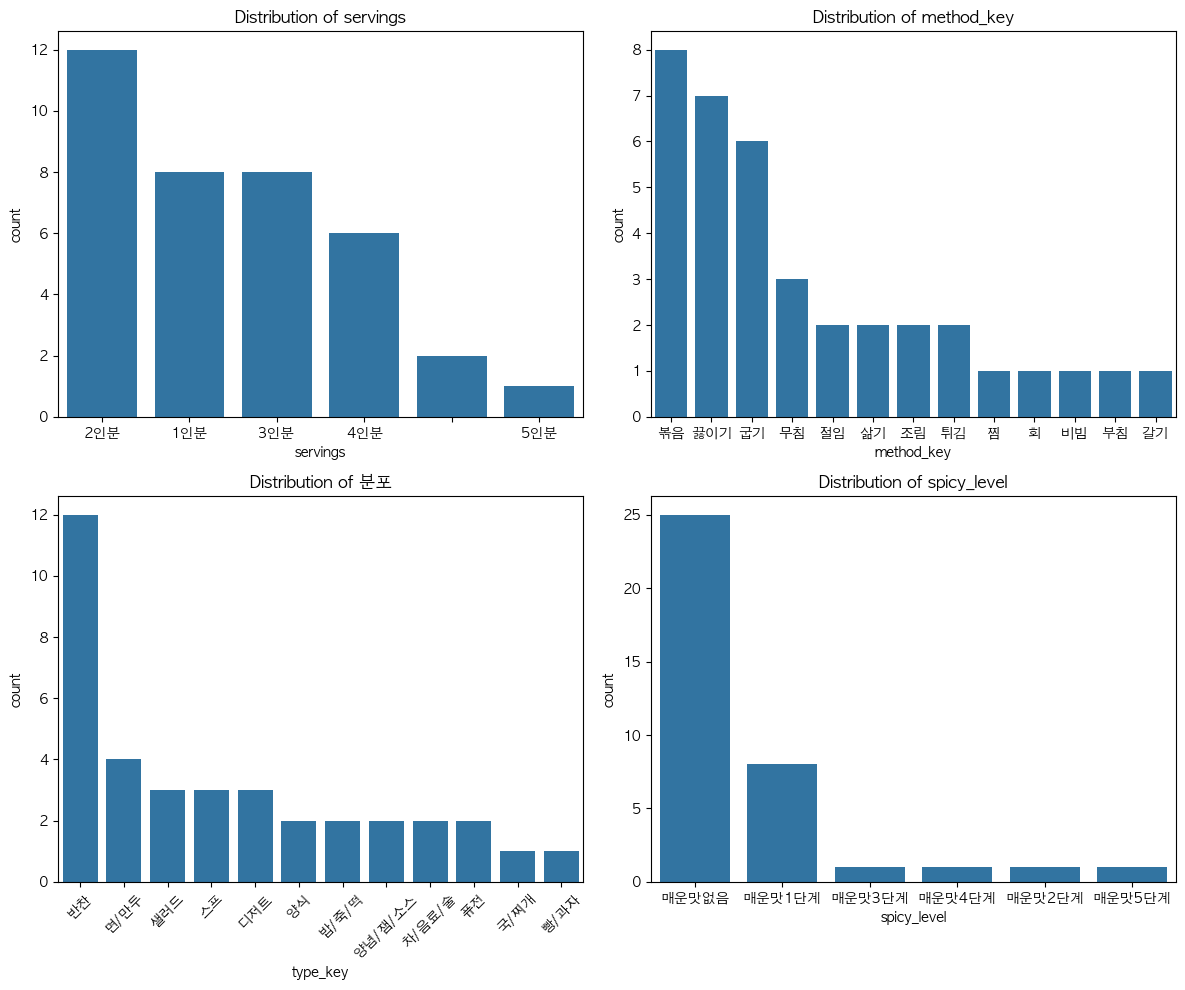

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['font.family'] = 'AppleGothic'  # Mac의 경우

# 각 컬럼에 대해 값을 집계하고 정렬
servings_order = df_sample['servings'].value_counts().sort_values(ascending=False).index
method_key_order = df_sample['method_key'].value_counts().sort_values(ascending=False).index
type_key_order = df_sample['type_key'].value_counts().sort_values(ascending=False).index
spicy_level_order = df_sample['spicy_level'].value_counts().sort_values(ascending=False).index

plt.figure(figsize=(12, 10))

# 서빙 분포
plt.subplot(2, 2, 1)
sns.countplot(x='servings', data=df_sample, order=servings_order)
plt.title('Distribution of servings')

# method_key 분포
plt.subplot(2, 2, 2)
sns.countplot(x='method_key', data=df_sample, order=method_key_order)
plt.title('Distribution of method_key')

# type_key 분포
plt.subplot(2, 2, 3)
sns.countplot(x='type_key', data=df_sample, order=type_key_order)
plt.title('Distribution of 분포')
plt.xticks(rotation=45)  # x축 레이블을 45도 회전

# spicy_level 분포
plt.subplot(2, 2, 4)
sns.countplot(x='spicy_level', data=df_sample, order=spicy_level_order)
plt.title('Distribution of spicy_level')

plt.tight_layout()
plt.show()
